# **LAB 5 - PART 1 Classification model (NN,CNN,LSTM) with Time Series Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import tensorflow as tf
from keras import Model,Input
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

import glob
from scipy import stats
import datetime as dt
from tqdm import tqdm

2024-03-05 19:29:15.645217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:29:15.645249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:29:15.646455: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 19:29:15.653528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 19:29:16.761007: W tensorflow/compiler/tf2

### **Data Preparation**

**Load csv from txt files**

**- Load Acceleration**

In [3]:
# Get filename of Acceleration

### START CODE HERE ###
fnames = glob.glob("./*_acceleration.txt")
def loadGlob(fnames,names,sep):
  testers = []
  for f in tqdm(fnames):
    tester = pd.read_csv(f,names=names,sep=sep)
    testers.append(tester)
  return pd.concat(testers)

# def resample(timeDf):
#   timedelta_unit = 's' # Define the timedelta_unit variable
#   resample_rule = '1s'
#   timeDf['timedelta'] = pd.DataFrame(pd.to_timedelta(timeDf['timedelta'], timedelta_unit).round(resample_rule))
#   tempDf = timeDf.groupby('timedelta').mean().reset_index() # average of the same second
#   return tempDf.set_index('timedelta')

ACC = loadGlob(fnames[:2],['timedelta', 'accX', 'accY', 'accZ'],' ')
### END CODE HERE ###

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


In [4]:
ACC

,timedelta,accX,accY,accZ
0,-12456.814733,0.260346,-0.222687,-0.939560
1,-12456.795310,0.280960,-0.214783,-0.933167
2,-12456.774080,0.275482,-0.249451,-0.906189
3,-12456.755424,0.287628,-0.247787,-0.881287
4,-12456.735441,0.302216,-0.244110,-0.850540
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


**- Load Heart Rate**

In [5]:
# Get filename of Heart Rate

### START CODE HERE ###
fnames = glob.glob("./*_heartrate.txt")


HeartR = loadGlob(fnames[0:2], ["timedelta", "heartrate"], ",")

100%|██████████| 2/2 [00:00<00:00, 402.18it/s]


In [6]:
HeartR

,timedelta,heartrate
0,-556410.36066,57.0
1,-556408.36062,56.0
2,-556403.36062,56.0
3,-556399.36062,57.0
4,-556389.36062,59.0
...,...,...
4367,14222.84187,60.0
4368,14231.84187,57.0
4369,14234.84187,56.0
4370,14239.84187,57.0


In [7]:
HeartR.isna().sum()

timedelta    0
heartrate    0
dtype: int64

**- Load Labeled Sleep**

In [8]:
# Get filename of Heart Rate

### START CODE HERE ###
fnames = glob.glob("./*_labeled_sleep.txt")


SleepL = loadGlob(fnames[0:2], ["timedelta", "sleep"], " ")
### END CODE HERE ###

100%|██████████| 2/2 [00:00<00:00, 655.05it/s]


**- If some Sleep levels are negative (-1) -> SleepL += 1**

In [9]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
470,14100,1
471,14130,0
472,14160,1
473,14190,1


**Synchronizes 'ACC', 'HeartR', 'SleepL'** by aligning their time ranges, <br>
and then filters each dataset to only include data within the overlapping time range.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

<br> ACC start: -124489.16105       ACC end: 37458.8583889
<br> HeartR start: -604720.29398    HeartR end: 37541.70998 
<br> SleepL start: 0                SleepL end: 29400 


In [10]:
### START CODE HERE ###

#Find max, min timedelta to find intersection time 
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_data = SleepL['timedelta'].min()


MIN_DATE = max(ACC_min_date, HeartR_min_date, SleepL_min_data)
MAX_DATE = min(ACC_max_date, HeartR_max_date, SleepL_max_date)

ACC = ACC[(ACC['timedelta'] >= MIN_DATE) & (ACC['timedelta'] <= MAX_DATE)]
SleepL = SleepL[(SleepL['timedelta'] >= MIN_DATE) & (SleepL['timedelta'] <= MAX_DATE)]
HeartR = HeartR[(HeartR['timedelta'] >= MIN_DATE) & (HeartR['timedelta'] <= MAX_DATE)]


print(ACC_min_date, ACC_max_date)
print(HeartR_min_date, HeartR_max_date)
print(SleepL_min_data, SleepL_max_date)
print(MIN_DATE, MAX_DATE)
# Obtain data for ACC, HeartR, and SleepL exclusively during the intersection period.
### END CODE HERE ###

-124489.16105 37458.8583889
-573407.48573 16980.47229
0 16980
0 16980


If your code is correct, this cell will execute without any issues.

In [11]:
# print(ACC.to_numpy().shape)
# print(HeartR.to_numpy().shape)
# print(SleepL.to_numpy().shape)
# assert ACC.to_numpy().shape == (4863482, 4)
# assert HeartR.to_numpy().shape == (28655, 2)
# assert SleepL.to_numpy().shape == (2967, 2)

Converts the `'timedelta'` column of the `ACC` DataFrame to a `pandas Timedelta object` in seconds and rounds it to the nearest second.

In [12]:
## START CODE HERE ###
timedelta_unit = 's'  # Define the timedelta_unit variable
resample_rule = '1s'
ACC['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC["timedelta"], timedelta_unit).round(resample_rule))
### END CODE HERE ###
ACC

/tmp/ipykernel_242415/906482662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC["timedelta"], timedelta_unit).round(resample_rule))


,timedelta,accX,accY,accZ
40157,0 days 00:00:00,-0.234604,0.643829,-0.713974
40158,0 days 00:00:00,-0.233948,0.622269,-0.643692
40159,0 days 00:00:00,-0.239273,0.616257,-0.657822
40160,0 days 00:00:00,-0.209808,0.640320,-0.660721
40161,0 days 00:00:00,-0.224426,0.641098,-0.685638
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


Groups the `ACC` DataFrame by `'timedelta'`, calculates the mean of `'accX', 'accY', and 'accZ'` for each group, and then concatenates these averages into a new DataFrame.

In [13]:
### START CODE HERE ###
df_acc = ACC.groupby('timedelta').mean().reset_index()
ACC = df_acc
### END CODE HERE ###
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.211796,0.833295,-0.137052
1,0 days 00:00:01,-0.304999,0.854863,0.021060
2,0 days 00:00:02,-0.368286,0.778982,0.054992
3,0 days 00:00:03,-0.288794,0.736335,-0.151884
4,0 days 00:00:04,0.236101,0.630011,-0.148900
...,...,...,...,...
16976,0 days 04:42:56,-0.500130,-0.051674,0.005909
16977,0 days 04:42:57,-0.499607,-0.051382,0.006221
16978,0 days 04:42:58,-0.499477,-0.051126,0.006785
16979,0 days 04:42:59,-0.500285,-0.046628,-0.000693


Converts the `'timedelta'` column of the `HeartR` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [14]:
### START CODE HERE ###
HeartR['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR["timedelta"],timedelta_unit).round(resample_rule))
HeartR = HeartR.set_index('timedelta').resample(resample_rule).median().ffill()
### END CODE HERE ###
HeartR

/tmp/ipykernel_242415/4270004800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR["timedelta"],timedelta_unit).round(resample_rule))


,heartrate
timedelta,
0 days 00:00:07,75.0
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,75.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


Converts the `'timedelta'` column of the `SleepL` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [15]:
### START CODE HERE ###
resample_rule = '1s'
SleepL['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL["timedelta"],timedelta_unit).round(resample_rule))
### END CODE HERE ###
SleepL


,timedelta,sleep
0,0 days 00:00:00,-1
1,0 days 00:00:30,-1
2,0 days 00:01:00,-1
3,0 days 00:01:30,-1
4,0 days 00:02:00,-1
...,...,...
470,0 days 03:55:00,1
471,0 days 03:55:30,0
472,0 days 03:56:00,1
473,0 days 03:56:30,1


Merges the `ACC, HeartR, and SleepL` DataFrames into a single DataFrame df, aligning them based on their `'timedelta'` columns using an asof merge.

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	      timedelta	   accX	      accY	       accZ	  heartrate	sleep
0	0 days 00:00:00	-0.143596	0.434711	-0.558406	NaN	NaN
1	0 days 00:00:01	-0.184721	0.438487	-0.492099	NaN	NaN
2	0 days 00:00:02	-0.213871	0.403676	-0.476563	65.0	NaN
3	0 days 00:00:03	-0.176616	0.391760	-0.571252	65.0	NaN
4	0 days 00:00:04	0.072789	0.338097	-0.571049	65.0	NaN

```

In [16]:
## START CODE HERE ###
#Sort
ACC = ACC.sort_values(by='timedelta')
HeartR = HeartR.sort_values(by='timedelta')
SleepL = SleepL.sort_values(by='timedelta')
df = pd.merge_asof(ACC, HeartR, on='timedelta')
df = pd.merge_asof(df, SleepL, on = 'timedelta')
### END CODE HERE ###
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.211796,0.833295,-0.137052,NaN,0
1,0 days 00:00:01,-0.304999,0.854863,0.021060,NaN,0
2,0 days 00:00:02,-0.368286,0.778982,0.054992,NaN,0
3,0 days 00:00:03,-0.288794,0.736335,-0.151884,NaN,0
4,0 days 00:00:04,0.236101,0.630011,-0.148900,NaN,0
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.500130,-0.051674,0.005909,76.0,0
16977,0 days 04:42:57,-0.499607,-0.051382,0.006221,76.0,0
16978,0 days 04:42:58,-0.499477,-0.051126,0.006785,76.0,0
16979,0 days 04:42:59,-0.500285,-0.046628,-0.000693,76.0,0


Fills missing values in the `'heartrate'` column with the column's median,<br> 
Fills missing values in the `'sleep'` column with 0,<br> 
and then drops the `'timedelta'` column from the df DataFrame.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	   accX	      accY	      accZ	heartrate	sleep
0	-0.143596	0.434711	-0.558406	62.0	0.0
1	-0.184721	0.438487	-0.492099	62.0	0.0
2	-0.213871	0.403676	-0.476563	65.0	0.0
3	-0.176616	0.391760	-0.571252	65.0	0.0
4	0.072789	0.338097	-0.571049	65.0	0.0
```

In [17]:
### START CODE HERE ###
df['heartrate'] = df['heartrate'].fillna(df['heartrate'].median())
df['sleep'] = df['sleep'].fillna(0)
df.drop(["timedelta"], axis=1, inplace=True)
### END CODE HERE ###
df

,accX,accY,accZ,heartrate,sleep
0,-0.211796,0.833295,-0.137052,74.5,0
1,-0.304999,0.854863,0.021060,74.5,0
2,-0.368286,0.778982,0.054992,74.5,0
3,-0.288794,0.736335,-0.151884,74.5,0
4,0.236101,0.630011,-0.148900,74.5,0
...,...,...,...,...,...
16976,-0.500130,-0.051674,0.005909,76.0,0
16977,-0.499607,-0.051382,0.006221,76.0,0
16978,-0.499477,-0.051126,0.006785,76.0,0
16979,-0.500285,-0.046628,-0.000693,76.0,0


In [18]:
df.isna().sum()

accX         0
accY         0
accZ         0
heartrate    0
sleep        0
dtype: int64

1. Separate X input[['accX', 'accY', 'accZ', 'heartrate'] ]and Y output[['sleep']]
2. Perform data scaling using Standardize,<br>
3. Perform SMA: Simple Moving Average to reduce noise in signals ,<br>

In [19]:
### START CODE HERE ###
feature_columns = ["accX", "accY", "accZ", "heartrate"]
label_columns = ["sleep"]

df_feature = df[feature_columns]
df_label = df[label_columns]

scaler = StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature), columns=feature_columns)

df_feature_SMA = pd.DataFrame()
wsize = 10
minp = 1
df_feature_SMA['accX'] = df_feature['accX'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accY'] = df_feature['accY'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accZ'] = df_feature['accZ'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['heartrate'] = df_feature['heartrate'].rolling(wsize, min_periods=minp).mean()
### END CODE HERE ###

Graph of all signals before and after Standardize and SMA
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

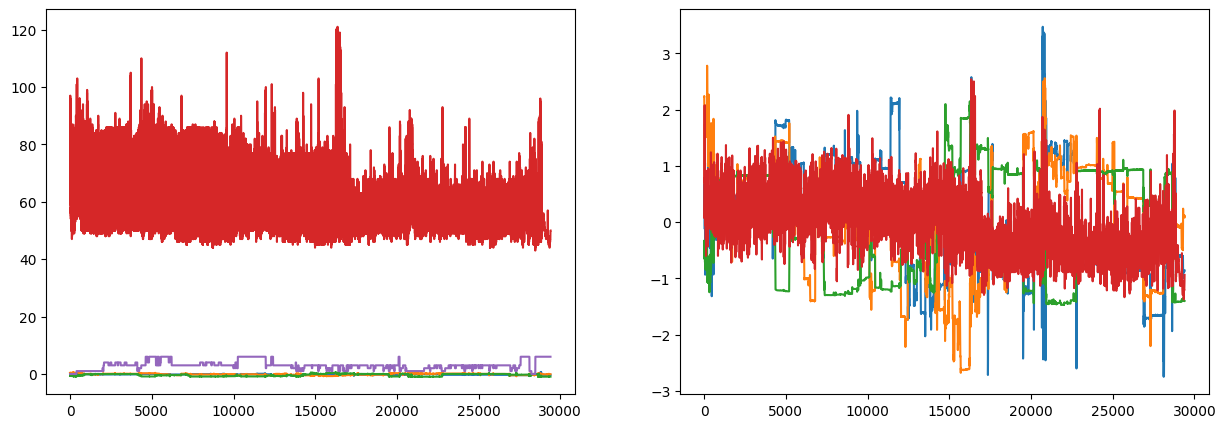

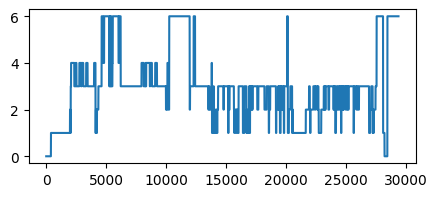

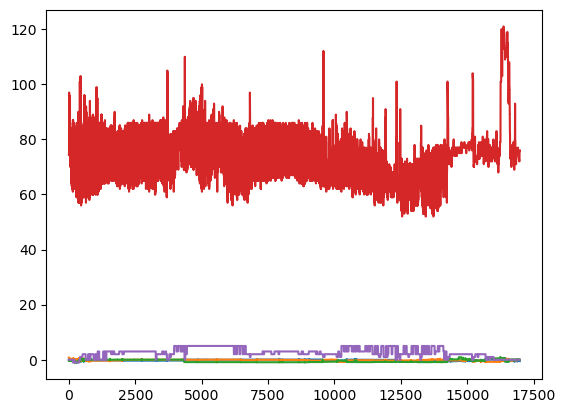

In [20]:
plt.plot(df)                
plt.show()

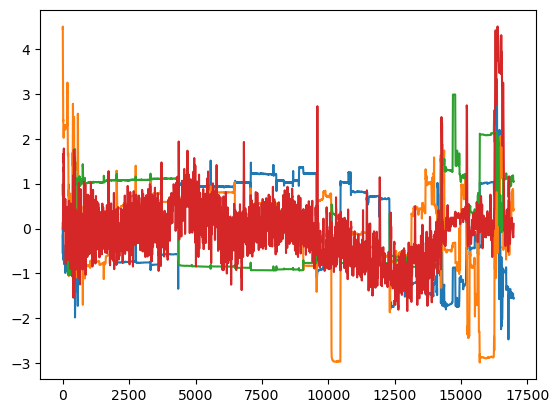

In [21]:
### START CODE HERE ###
# Before Standardize and SMA
# After
plt.plot(df_feature_SMA)
plt.show()
### END CODE HERE ###

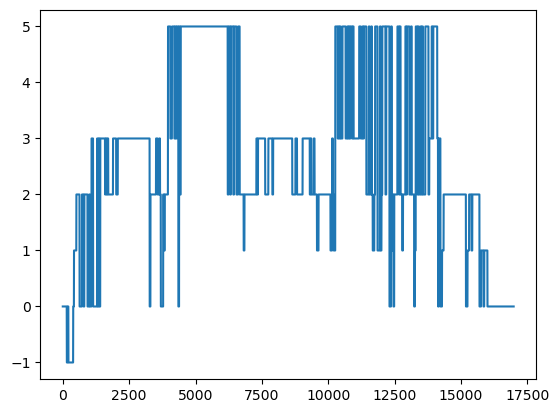

In [22]:
# Graph Sleep labels
plt.plot(df_label)

### **Model Experimentaion**

**Train Test Data Preparation**

In [23]:
X = df_feature_SMA
y = df_label

In [24]:
random_state = 42

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.5,  test_size = 0.3, random_state=random_state)

##### **Neural Network**
**Create MLP (NN) Model Architecture**

In [26]:
hiddenL = (50, 50, 50)
act = 'relu'
EP = 10000
lr = 0.01
optimizer = 'adam'
SEED_init = None
tolr = 0.0
mlp = MLPClassifier(hidden_layer_sizes=hiddenL,activation=act ,max_iter=EP, alpha=lr,solver=optimizer, random_state=random_state,tol=tolr)
mlp

MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50, 50), max_iter=10000,
              random_state=42, tol=0.0)

**Traning MLP (NN) Model**

In [27]:
x_train

,accX,accY,accZ,heartrate
16064,1.021474,-2.865443,2.086246,0.191668
11934,0.503575,-0.503824,-0.664835,0.735438
6366,0.925699,0.809284,-0.847878,-0.575437
2527,-0.730793,0.515408,1.073995,0.332465
14317,-1.297757,1.637791,1.443325,0.113986
...,...,...,...,...
3348,-0.807490,0.753410,1.107062,-0.526886
4079,-0.574226,0.595850,1.117045,0.735438
9177,1.222613,-0.829779,-0.766608,0.337320
10013,-0.815941,0.719087,-0.503076,-0.245291


In [28]:
mlp.fit(x_train, y_train)

/home/ss/.conda/envs/ML_Lab/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50, 50), max_iter=10000,
              random_state=42, tol=0.0)

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       192
           1       0.86      0.73      0.79      1246
           2       0.77      0.35      0.48      1224
           3       0.84      0.82      0.83      4153
           4       0.64      0.75      0.69       603
           5       0.88      0.88      0.88      1403

   micro avg       0.83      0.74      0.78      8821
   macro avg       0.80      0.71      0.74      8821
weighted avg       0.82      0.74      0.77      8821
 samples avg       0.73      0.74      0.73      8821
```
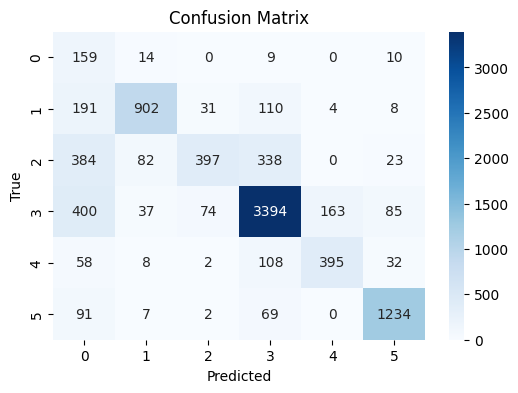

**MLP (NN) Model Prediction**

In [29]:
y_pred = mlp.predict(x_test)

**MLP (NN) Model Performance (Confusion Matrix, Classification_report)**


In [30]:
print('----- Classification Report of MLP NN predict X_test -----')
print(classification_report(y_test, y_pred))
print('----- Confusion matrix of MLP NN predict X_test -----')
print(confusion_matrix(y_test, y_pred))

----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

          -1       0.90      0.91      0.91        70
           0       0.72      0.85      0.78       627
           1       0.65      0.36      0.46       290
           2       0.75      0.72      0.73      1562
           3       0.71      0.79      0.75      1283
           5       0.81      0.76      0.78      1263

    accuracy                           0.75      5095
   macro avg       0.76      0.73      0.74      5095
weighted avg       0.75      0.75      0.74      5095

----- Confusion matrix of MLP NN predict X_test -----
[[  64    6    0    0    0    0]
 [   4  532    3   46   22   20]
 [   2   78  103   75    2   30]
 [   0   40   25 1125  270  102]
 [   1   69   14  106 1016   77]
 [   0   14   13  157  117  962]]


##### **Train-Test Data Preparation for CNN Training**
1. Non-Transpose Data (XR Shape1: sliding window size, n_feature)
2. Transpose Data  (XT Shape2: n_feature, sliding window size)

**Non-Transpose data (XR)**



In [31]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, 

X = df_feature_SMA
Y = df_label
XR = [ ]

#Xr shape
# (X.size, slidingW, X.shape[1], 1),
#Xt shape
# (X.size, X.shape[1],slidingW, 1),

print(XR)
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])        
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)  
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])         
    # Majority vote : mode of labels for whole array 
    mode_values, countL = stats.mode(label,axis=None) 
    label = mode_values
    
    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
y = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
y = pd.get_dummies(y.astype(int), columns=['Sleep_Label'])
yR = y

[]


In [32]:
yR

,Sleep_Label_-1,Sleep_Label_0,Sleep_Label_1,Sleep_Label_2,Sleep_Label_3,Sleep_Label_5
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
1684,False,True,False,False,False,False
1685,False,True,False,False,False,False
1686,False,True,False,False,False,False
1687,False,True,False,False,False,False


In [33]:
XR

array([[[[-1.52421518e-01],
         [ 4.45112941e+00],
         [ 7.41775402e-01],
         [-2.53605046e-03]],

        [[-3.79485559e-01],
         [ 4.50018812e+00],
         [ 9.12009290e-01],
         [-2.53605046e-03]],

        [[-5.57961169e-01],
         [ 4.40147036e+00],
         [ 9.93109488e-01],
         [-2.53605046e-03]],

        ...,

        [[-8.86504234e-01],
         [ 2.25135328e+00],
         [ 3.61862807e-04],
         [ 5.60654710e-01]],

        [[-8.55271530e-01],
         [ 2.26720868e+00],
         [ 3.56323142e-03],
         [ 4.34422298e-01]],

        [[-8.23518909e-01],
         [ 2.28257073e+00],
         [ 7.07989638e-03],
         [ 4.53842669e-01]]],


       [[[-3.91841036e-01],
         [ 3.19759455e+00],
         [ 7.37684916e-01],
         [ 6.57756565e-01]],

        [[-3.81536996e-01],
         [ 2.93618446e+00],
         [ 6.79969848e-01],
         [ 6.62611658e-01]],

        [[-3.31781082e-01],
         [ 2.75454390e+00],
         [ 6.110

In [34]:
yR

,Sleep_Label_-1,Sleep_Label_0,Sleep_Label_1,Sleep_Label_2,Sleep_Label_3,Sleep_Label_5
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
1684,False,True,False,False,False,False
1685,False,True,False,False,False,False
1686,False,True,False,False,False,False
1687,False,True,False,False,False,False


**Non-Transpose Tran_test_split data**

In [35]:
#----- CNN with XR -----------
#--- Train - Validate - Test ----
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state=random_state)

In [36]:
yR.shape

(1689, 6)

##### **CNN Architecture (XR)**

In [37]:
CNN_L1 = 32
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yR.shape[1]
learning_rate = 0.01

pDrop = 0.4

Input_shape = (slidingW, n_feature, 1)
P_size = (2,1)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, padding='same', activation=Act_func, input_shape=Input_shape))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass, activation='sigmoid'))

adam = optimizers.Adam(learning_rate)
model.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 4, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 4, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 4, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 4, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 4, 128)        0

##### **Train CNN(XR)**

In [38]:
historyXR = model.fit(XR_train, yR_train, epochs=100, validation_data=(XR_test, yR_test))

Epoch 1/100
37/37 [==============================] - 3s 67ms/step - loss: 1.7469 - acc: 0.3917 - val_loss: 1.2342 - val_acc: 0.4615
Epoch 2/100
37/37 [==============================] - 2s 65ms/step - loss: 1.1082 - acc: 0.5305 - val_loss: 1.0988 - val_acc: 0.5503
Epoch 3/100
37/37 [==============================] - 2s 65ms/step - loss: 1.0358 - acc: 0.5550 - val_loss: 0.9710 - val_acc: 0.5897
Epoch 4/100
37/37 [==============================] - 2s 64ms/step - loss: 0.9960 - acc: 0.5508 - val_loss: 0.9607 - val_acc: 0.5325
Epoch 5/100
37/37 [==============================] - 2s 56ms/step - loss: 0.8846 - acc: 0.5846 - val_loss: 0.8249 - val_acc: 0.6391
Epoch 6/100
37/37 [==============================] - 2s 59ms/step - loss: 0.8227 - acc: 0.6311 - val_loss: 0.8874 - val_acc: 0.6036
Epoch 7/100
37/37 [==============================] - 2s 59ms/step - loss: 0.8487 - acc: 0.5981 - val_loss: 0.8960 - val_acc: 0.5917
Epoch 8/100
37/37 [==============================] - 3s 69ms/step - loss: 0.

37/37 [==============================] - 3s 94ms/step - loss: 0.7877 - acc: 0.6337 - val_loss: 0.8637 - val_acc: 0.6095
Epoch 20/100
37/37 [==============================] - 4s 108ms/step - loss: 0.7546 - acc: 0.6701 - val_loss: 0.8389 - val_acc: 0.6193
Epoch 21/100
37/37 [==============================] - 3s 88ms/step - loss: 0.7188 - acc: 0.6489 - val_loss: 0.9679 - val_acc: 0.5996
Epoch 22/100
37/37 [==============================] - 3s 91ms/step - loss: 0.7276 - acc: 0.6565 - val_loss: 0.8109 - val_acc: 0.6450
Epoch 23/100
37/37 [==============================] - 3s 75ms/step - loss: 0.7531 - acc: 0.6616 - val_loss: 0.8102 - val_acc: 0.6509
Epoch 24/100
37/37 [==============================] - 3s 69ms/step - loss: 0.6558 - acc: 0.6946 - val_loss: 0.7613 - val_acc: 0.6647
Epoch 25/100
37/37 [==============================] - 2s 58ms/step - loss: 0.6438 - acc: 0.6929 - val_loss: 0.7167 - val_acc: 0.6884
Epoch 26/100
37/37 [==============================] - 2s 55ms/step - loss: 0.5734

##### **CNN (XR) Performance**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

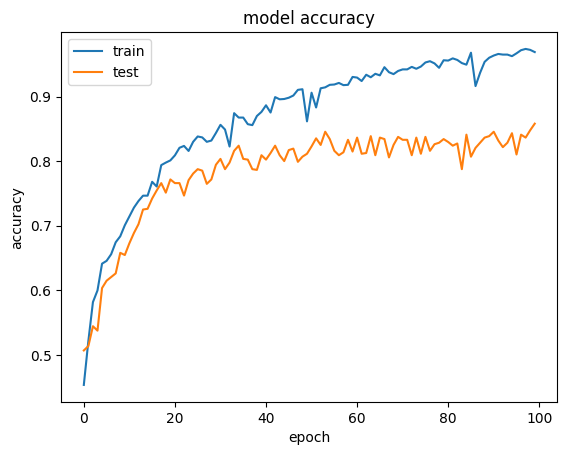
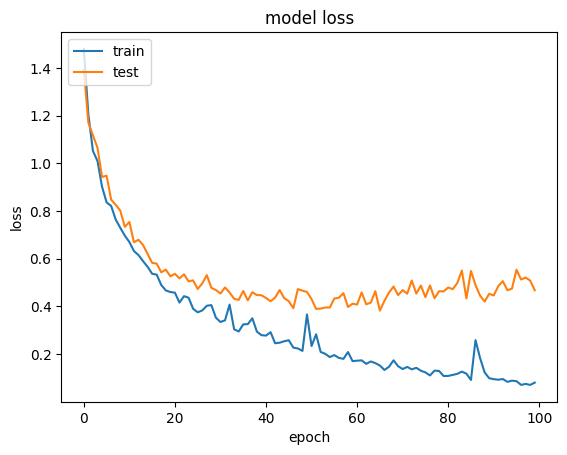

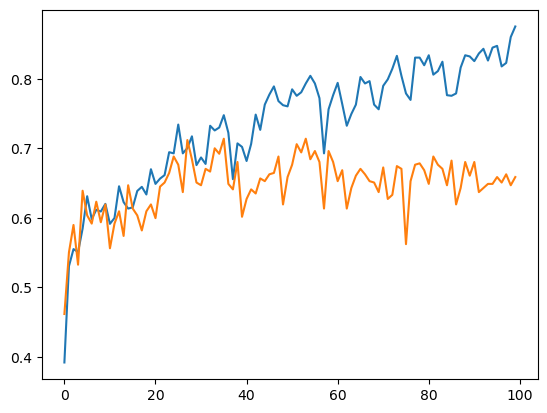

In [39]:
# summarize history for accuracy
history = historyXR
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

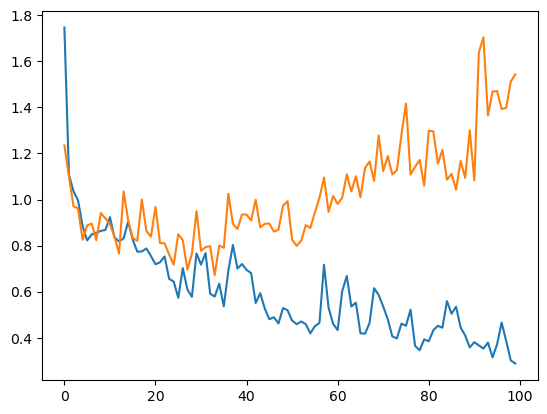

In [40]:
# summarize history for loss
history=historyXR
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

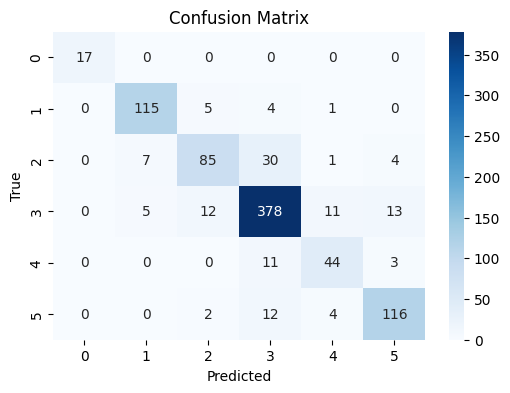

```
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.92      0.91       125
           2       0.82      0.67      0.74       127
           3       0.87      0.90      0.89       419
           4       0.72      0.76      0.74        58
           5       0.85      0.87      0.86       134

    accuracy                           0.86       880
   macro avg       0.86      0.85      0.86       880
weighted avg       0.86      0.86      0.86       880
```

In [41]:
CNN_pred = model.predict(XR_test)
# Convert  nn output to label
y_pred = np.argmax(CNN_pred, axis=1)
y_true = np.argmax(np.array(yR_test), axis=1)

16/16 [==============================] - 0s 9ms/step


----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.66      0.57      0.61        69
           2       0.44      0.30      0.36        23
           3       0.68      0.55      0.61       154
           4       0.54      0.75      0.63       121
           5       0.80      0.80      0.80       135

    accuracy                           0.66       507
   macro avg       0.65      0.63      0.63       507
weighted avg       0.67      0.66      0.66       507

----- Confusion matrix of CNN predict X_test -----
[[  4   1   0   0   0   0]
 [  1  39   3  16   8   2]
 [  0   7   7   5   1   3]
 [  0   6   1  85  55   7]
 [  0   6   1   8  91  15]
 [  0   0   4  11  12 108]]


<Axes: >

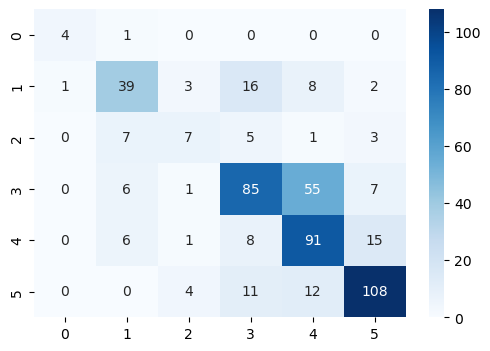

In [42]:
print('----- Classification Report of CNN predict X_test -----')

print(classification_report(y_true, y_pred))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

### **Transpose data (XT)**

In [43]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = np.array(X.iloc[i: i+slidingW])        
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW, 1)
    # label sliding windows = df_label[i:i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])         
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(label,axis=None) 

    label = mode_values
    
    XT.append(featureT)
    y.append(label)

XT = np.array(XT)
y = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yT
y = pd.get_dummies(y.astype(int), columns=['Sleep_Label'])
yT = y

In [44]:
XT

array([[[[-1.52421518e-01],
         [-3.79485559e-01],
         [-5.57961169e-01],
         ...,
         [-8.86504234e-01],
         [-8.55271530e-01],
         [-8.23518909e-01]],

        [[ 4.45112941e+00],
         [ 4.50018812e+00],
         [ 4.40147036e+00],
         ...,
         [ 2.25135328e+00],
         [ 2.26720868e+00],
         [ 2.28257073e+00]],

        [[ 7.41775402e-01],
         [ 9.12009290e-01],
         [ 9.93109488e-01],
         ...,
         [ 3.61862807e-04],
         [ 3.56323142e-03],
         [ 7.07989638e-03]],

        [[-2.53605046e-03],
         [-2.53605046e-03],
         [-2.53605046e-03],
         ...,
         [ 5.60654710e-01],
         [ 4.34422298e-01],
         [ 4.53842669e-01]]],


       [[[-3.91841036e-01],
         [-3.81536996e-01],
         [-3.31781082e-01],
         ...,
         [-7.69396617e-01],
         [-7.72066305e-01],
         [-7.76849929e-01]],

        [[ 3.19759455e+00],
         [ 2.93618446e+00],
         [ 2.75454390e

In [45]:
yT

,Sleep_Label_-1,Sleep_Label_0,Sleep_Label_1,Sleep_Label_2,Sleep_Label_3,Sleep_Label_5
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
1684,False,True,False,False,False,False
1685,False,True,False,False,False,False
1686,False,True,False,False,False,False
1687,False,True,False,False,False,False


##### **Train Test Split (XT)**

In [46]:
#----- CNN with XT -----------
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.3,random_state=random_state)

##### **CNN Architecture (XT)**

In [47]:
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yT.shape[1]
print(Nclass)

Input_shape = (n_feature, slidingW, 1)
P_size = (1,2)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, padding='same', activation=Act_func, input_shape=Input_shape))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, padding='same', activation=Act_func))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass, activation='sigmoid'))

adam = optimizers.Adam(learning_rate)
model.compile(optimizer=adam, loss= tf.keras.losses.categorical_crossentropy, metrics=["acc"])
model.summary()

6
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 4, 100, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 50, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 50, 64)         9280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 25, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 25, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 12, 128)     

##### **Train CNN (XT)**

In [48]:
historyXT = model.fit(XT_train, yT_train, epochs=100, validation_data=(XT_test, yT_test))

Epoch 1/100
37/37 [==============================] - 3s 57ms/step - loss: 1.6461 - acc: 0.3587 - val_loss: 1.2416 - val_acc: 0.4320
Epoch 2/100
37/37 [==============================] - 2s 50ms/step - loss: 1.1915 - acc: 0.5042 - val_loss: 1.0786 - val_acc: 0.5424
Epoch 3/100
37/37 [==============================] - 2s 51ms/step - loss: 1.0131 - acc: 0.5609 - val_loss: 0.9819 - val_acc: 0.5740
Epoch 4/100
37/37 [==============================] - 2s 51ms/step - loss: 0.9602 - acc: 0.5609 - val_loss: 0.9231 - val_acc: 0.5917
Epoch 5/100
37/37 [==============================] - 2s 51ms/step - loss: 1.1012 - acc: 0.5102 - val_loss: 1.1798 - val_acc: 0.5444
Epoch 6/100
37/37 [==============================] - 2s 62ms/step - loss: 0.9990 - acc: 0.5854 - val_loss: 0.8746 - val_acc: 0.6134
Epoch 7/100
37/37 [==============================] - 2s 51ms/step - loss: 0.8605 - acc: 0.6083 - val_loss: 0.9134 - val_acc: 0.5345
Epoch 8/100
37/37 [==============================] - 2s 53ms/step - loss: 0.

37/37 [==============================] - 2s 54ms/step - loss: 0.7265 - acc: 0.6633 - val_loss: 0.7157 - val_acc: 0.6903
Epoch 16/100
37/37 [==============================] - 2s 52ms/step - loss: 0.6726 - acc: 0.6912 - val_loss: 0.7310 - val_acc: 0.7219
Epoch 17/100
37/37 [==============================] - 2s 50ms/step - loss: 0.6758 - acc: 0.6929 - val_loss: 0.7605 - val_acc: 0.6844
Epoch 18/100
37/37 [==============================] - 2s 51ms/step - loss: 0.6971 - acc: 0.6920 - val_loss: 0.7523 - val_acc: 0.6844
Epoch 19/100
37/37 [==============================] - 2s 50ms/step - loss: 1.0732 - acc: 0.5728 - val_loss: 0.9049 - val_acc: 0.5700
Epoch 20/100
37/37 [==============================] - 2s 50ms/step - loss: 0.8527 - acc: 0.6176 - val_loss: 0.8096 - val_acc: 0.6272
Epoch 21/100
37/37 [==============================] - 2s 65ms/step - loss: 0.7606 - acc: 0.6438 - val_loss: 0.8892 - val_acc: 0.6174
Epoch 22/100
37/37 [==============================] - 2s 58ms/step - loss: 0.7801 

##### **CNN Performance (XT)**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

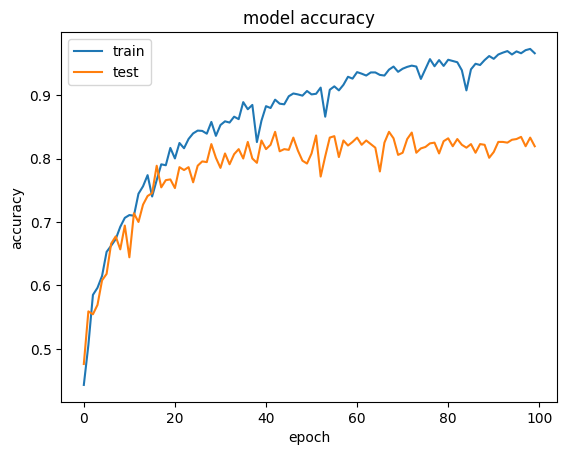
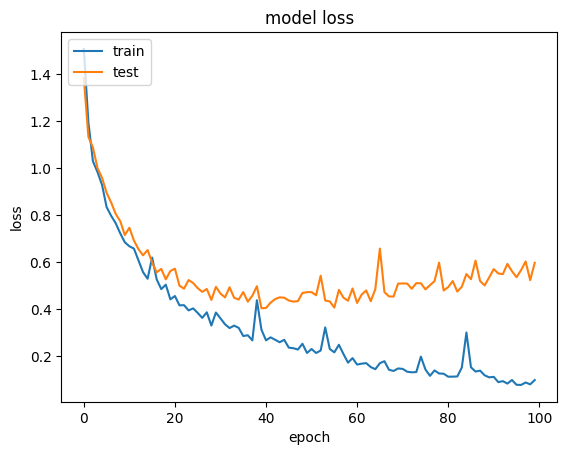

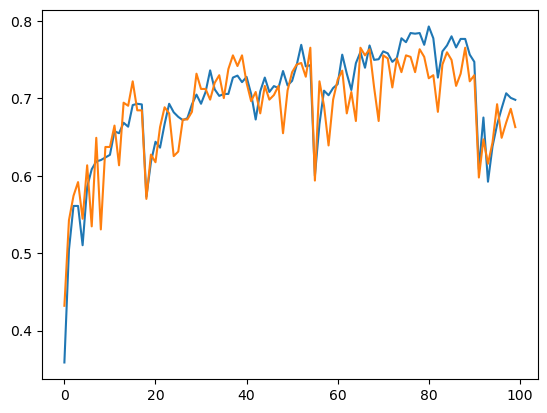

In [49]:
# summarize history for accuracy
history = historyXT
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

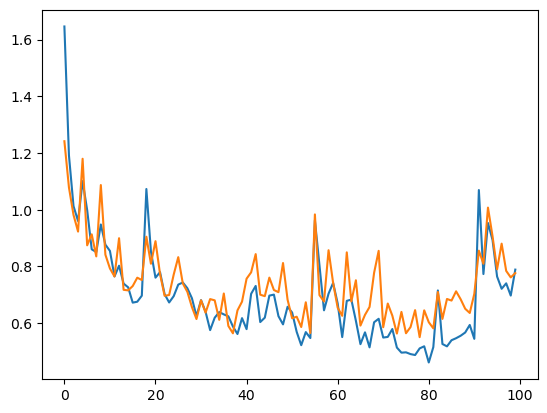

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

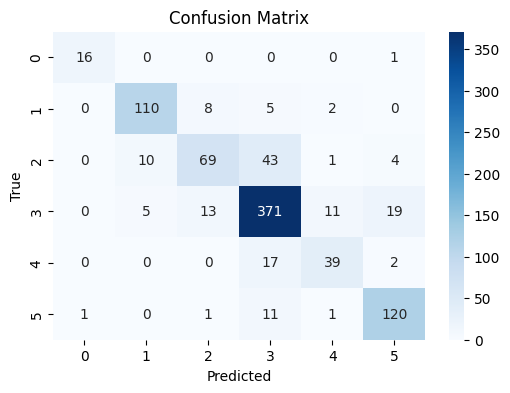

```
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.88      0.88      0.88       125
           2       0.76      0.54      0.63       127
           3       0.83      0.89      0.86       419
           4       0.72      0.67      0.70        58
           5       0.82      0.90      0.86       134

    accuracy                           0.82       880
   macro avg       0.83      0.80      0.81       880
weighted avg       0.82      0.82      0.82       880
```

In [51]:

CNN_pred = model.predict(XT_test)
# Convert  nn output to label
y_pred = np.argmax(CNN_pred, axis=1)
y_true = np.argmax(np.array(yT_test), axis=1)

16/16 [==============================] - 0s 11ms/step


----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      0.58      0.70        69
           2       0.36      0.39      0.37        23
           3       0.66      0.52      0.58       154
           4       0.56      0.84      0.67       121
           5       0.78      0.74      0.76       135

    accuracy                           0.66       507
   macro avg       0.71      0.68      0.68       507
weighted avg       0.69      0.66      0.66       507

----- Confusion matrix of CNN predict X_test -----
[[  5   0   0   0   0   0]
 [  0  40   7  12   7   3]
 [  0   0   9   7   0   7]
 [  0   4   4  80  61   5]
 [  0   1   1   3 102  14]
 [  0   0   4  19  12 100]]


<Axes: >

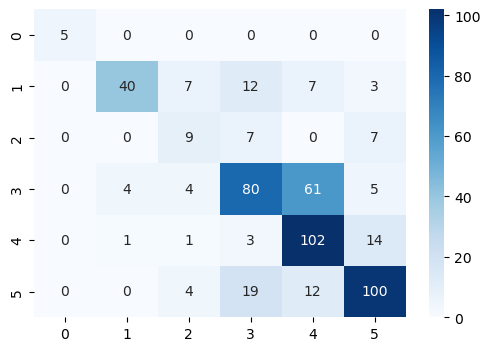

In [52]:
print('----- Classification Report of CNN predict X_test -----')

print(classification_report(y_true, y_pred))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

### **Long Short Term Memory (LSTM)**

**Train-Test Data Preparation**
LSTM Use data XR, XT same as CNN

##### **Prepare (XR) Data**

In [53]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, 

X = df_feature_SMA
Y = df_label
XR = [ ]

print(XR)
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])        
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)  
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])         
    # Majority vote : mode of labels for whole array 
    mode_values, countL = stats.mode(label,axis=None) 
    label = mode_values
    
    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
y = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
y = pd.get_dummies(y.astype(int), columns=['Sleep_Label'])
yR = y

[]


In [54]:
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state=random_state)

##### **LSTM (XR) Model Architecture**

In [55]:
#LSTM 2 Layers
Nodes = [50, 100, 150, 200, 250, 350, 500]
n_hidden1 = Nodes[1]
n_hidden2 = Nodes[4]

Nclass = yR.shape[1]
dropRate_L1 = 0.25
dropRate_L2 = 0.5
Input_shape = (slidingW, n_feature)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(dropRate_L1))

model.add(LSTM(n_hidden2))
model.add(Dropout(dropRate_L2))
model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          42000     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 250)               351000    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1506      
                                                                 
Total params: 394506 (1.50 MB)
Trainable params: 394506 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [56]:
# Compiling the model
adam = optimizers.Adam(learning_rate=0.010)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

##### **Training LSTM (XR) Model**

In [57]:
# Training the model
EP = 100
batch_size = None

historyL_XR = model.fit(XR_train, yR_train, epochs=EP, batch_size=batch_size, validation_data=(XR_test, yR_test))

Epoch 1/100
37/37 [==============================] - 19s 386ms/step - loss: 1.5075 - acc: 0.3596 - val_loss: 1.3462 - val_acc: 0.3984
Epoch 2/100
37/37 [==============================] - 12s 335ms/step - loss: 1.3899 - acc: 0.4061 - val_loss: 1.3827 - val_acc: 0.3590
Epoch 3/100
 1/37 [..............................] - ETA: 10s - loss: 1.5717 - acc: 0.3125

37/37 [==============================] - 12s 337ms/step - loss: 1.3771 - acc: 0.4154 - val_loss: 1.3341 - val_acc: 0.4793
Epoch 4/100
37/37 [==============================] - 14s 368ms/step - loss: 1.4182 - acc: 0.3604 - val_loss: 1.2954 - val_acc: 0.4162
Epoch 5/100
37/37 [==============================] - 12s 332ms/step - loss: 1.2991 - acc: 0.4340 - val_loss: 1.1752 - val_acc: 0.4970
Epoch 6/100
37/37 [==============================] - 12s 323ms/step - loss: 1.3635 - acc: 0.4171 - val_loss: 1.2701 - val_acc: 0.4201
Epoch 7/100
37/37 [==============================] - 12s 332ms/step - loss: 1.2834 - acc: 0.4247 - val_loss: 1.1610 - val_acc: 0.5108
Epoch 8/100
37/37 [==============================] - 13s 344ms/step - loss: 1.1961 - acc: 0.5152 - val_loss: 1.6893 - val_acc: 0.4734
Epoch 9/100
37/37 [==============================] - 12s 334ms/step - loss: 1.5322 - acc: 0.4416 - val_loss: 1.2634 - val_acc: 0.5266
Epoch 10/100
37/37 [==============================] - 12s 333ms/step - los

 **LSTM (XR) Model Performance**

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

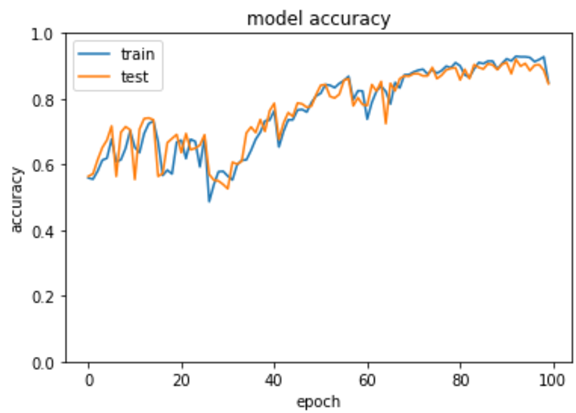

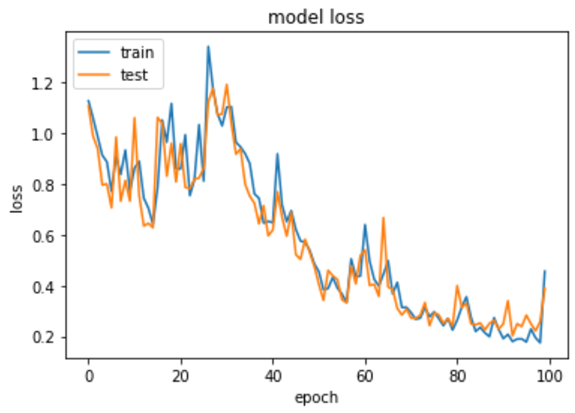

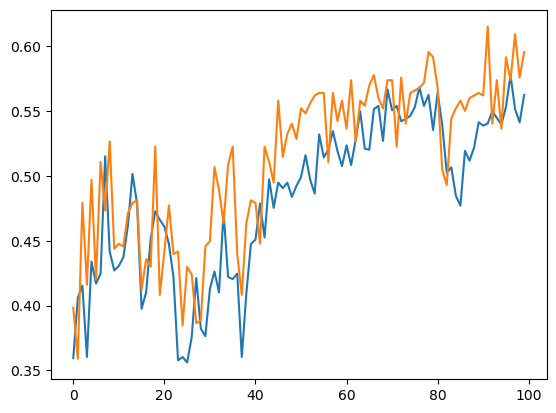

In [58]:
# summarize history for accuracy
history = historyL_XR
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


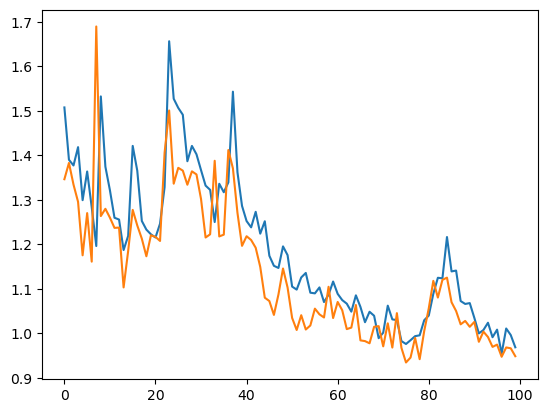

In [59]:
# summarize history for loss
history = historyL_XR
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

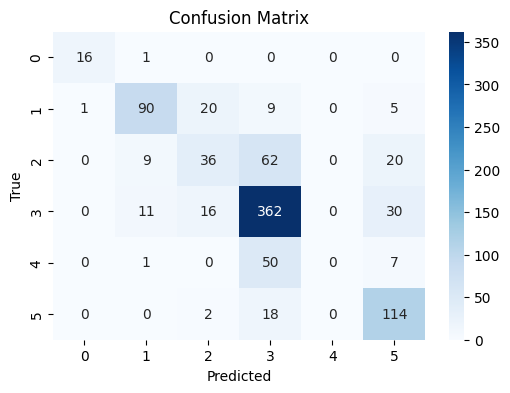

```
             precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.80      0.72      0.76       125
           2       0.49      0.28      0.36       127
           3       0.72      0.86      0.79       419
           4       0.00      0.00      0.00        58
           5       0.65      0.85      0.74       134

    accuracy                           0.70       880
   macro avg       0.60      0.61      0.60       880
weighted avg       0.65      0.70      0.66       880

```

In [61]:
CNN_pred = model.predict(XR_test)
# Convert  nn output to label
y_pred = np.argmax(CNN_pred, axis=1)
y_true = np.argmax(np.array(yR_test), axis=1)

16/16 [==============================] - 2s 102ms/step


----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.70      0.23      0.35        69
           2       0.35      0.26      0.30        23
           3       0.56      0.66      0.61       154
           4       0.55      0.73      0.62       121
           5       0.72      0.65      0.68       135

    accuracy                           0.60       507
   macro avg       0.65      0.49      0.52       507
weighted avg       0.61      0.60      0.58       507

----- Confusion matrix of CNN predict X_test -----
[[  2   1   1   1   0   0]
 [  0  16   6  35   8   4]
 [  0   3   6   7   0   7]
 [  0   1   1 102  40  10]
 [  0   2   1  17  88  13]
 [  0   0   2  20  25  88]]


<Axes: >

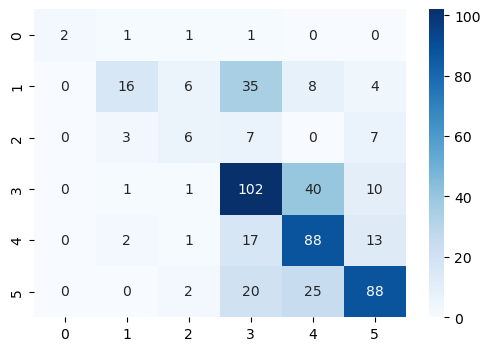

In [62]:
print('----- Classification Report of CNN predict X_test -----')

print(classification_report(y_true, y_pred))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

##### **Prepare (XT) Data**

In [63]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = np.array(X.iloc[i: i+slidingW])        
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW, 1)
    # label sliding windows = df_label[i:i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])         
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(label,axis=None) 

    label = mode_values
    
    XT.append(featureT)
    y.append(label)

XT = np.array(XT)
y = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yT
y = pd.get_dummies(y.astype(int), columns=['Sleep_Label'])
yT = y

In [64]:
#----- LSTM with XT -----------
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.3,random_state=random_state)

##### **Create LSTM (XT) Model Architecture**

In [65]:
#LSTM 2 Layers
Nodes = [50, 100, 150, 200, 250, 350, 500]
n_hidden1 = Nodes[1]
n_hidden2 = Nodes[4]

Nclass = yR.shape[1]
dropRate_L1 = 0.25
dropRate_L2 = 0.5
Input_shape = (n_feature, slidingW)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(dropRate_L1))

model.add(LSTM(n_hidden2))
model.add(Dropout(dropRate_L2))
model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 4, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 250)               351000    
                                                                 
 dropout_5 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1506      
                                                                 
Total params: 432906 (1.65 MB)
Trainable params: 432906 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [66]:
# Compiling the model
adam = optimizers.Adam(learning_rate=0.010)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

In [67]:
# Training the model
EP = 100
batch_size = None

historyL_XR = model.fit(XT_train, yT_train, epochs=EP, batch_size=batch_size, validation_data=(XT_test, yT_test))

Epoch 1/100
37/37 [==============================] - 7s 64ms/step - loss: 1.4716 - acc: 0.3892 - val_loss: 1.1706 - val_acc: 0.5345
Epoch 2/100
37/37 [==============================] - 1s 25ms/step - loss: 1.2556 - acc: 0.4822 - val_loss: 1.1408 - val_acc: 0.4832
Epoch 3/100
37/37 [==============================] - 1s 20ms/step - loss: 1.0305 - acc: 0.5364 - val_loss: 0.9614 - val_acc: 0.5858
Epoch 4/100
37/37 [==============================] - 1s 16ms/step - loss: 0.9599 - acc: 0.5905 - val_loss: 0.9435 - val_acc: 0.5878
Epoch 5/100
37/37 [==============================] - 1s 17ms/step - loss: 0.8503 - acc: 0.6294 - val_loss: 0.8013 - val_acc: 0.6706
Epoch 6/100
37/37 [==============================] - 1s 16ms/step - loss: 0.8107 - acc: 0.6472 - val_loss: 0.7844 - val_acc: 0.7041
Epoch 7/100
37/37 [==============================] - 1s 15ms/step - loss: 0.7515 - acc: 0.6760 - val_loss: 0.8301 - val_acc: 0.6588
Epoch 8/100
37/37 [==============================] - 1s 17ms/step - loss: 0.

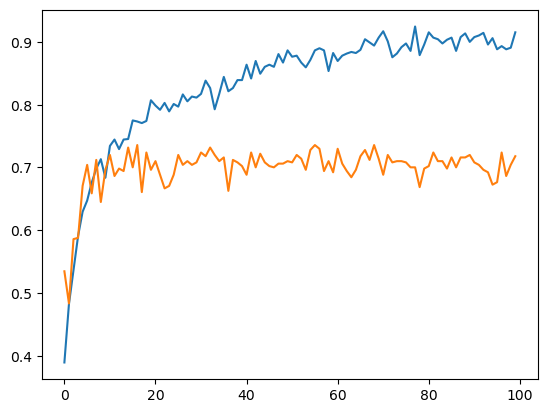

In [68]:
# summarize history for accuracy
history = historyL_XR
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

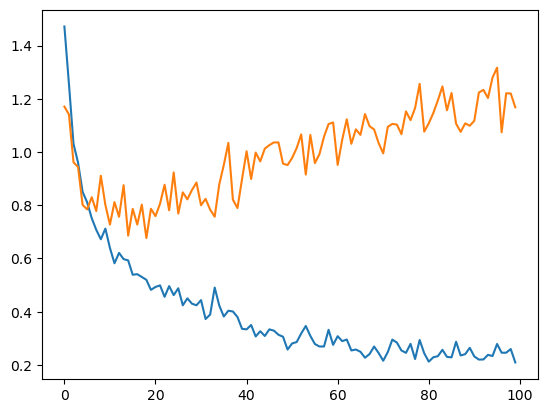

In [69]:
# summarize history for loss
history = historyL_XR
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


In [71]:

CNN_pred = model.predict(XT_test)
# Convert  nn output to label
y_pred = np.argmax(CNN_pred, axis=1)
y_true = np.argmax(np.array(yT_test), axis=1)

16/16 [==============================] - 1s 8ms/step


----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.75      0.70      0.72        69
           2       0.56      0.39      0.46        23
           3       0.67      0.71      0.69       154
           4       0.66      0.69      0.67       121
           5       0.82      0.81      0.81       135

    accuracy                           0.72       507
   macro avg       0.72      0.72      0.71       507
weighted avg       0.72      0.72      0.72       507

----- Confusion matrix of CNN predict X_test -----
[[  5   0   0   0   0   0]
 [  1  48   4   9   4   3]
 [  0   4   9   9   0   1]
 [  0   8   2 110  26   8]
 [  0   4   0  22  83  12]
 [  0   0   1  13  12 109]]


<Axes: >

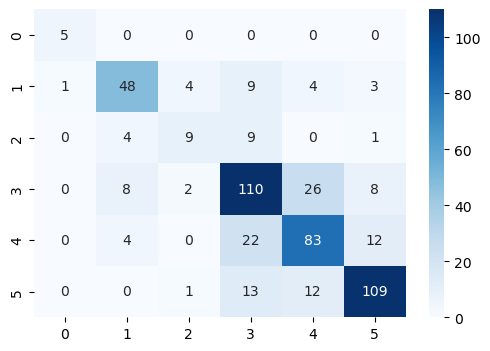

In [72]:
print('----- Classification Report of CNN predict X_test -----')

print(classification_report(y_true, y_pred))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')